### TRANSFER LEARNING CUANTICO PARA CLASIFICAR ROSTROS CON MASCARILLA COVID-19

- Autor: Soto Paredes, Christian


In [ ]:
#Pennylane
!pip install git+https://github.com/PennyLaneAI/pennylane.git # instalacion pennylane version de desarrollo (no estable) porque maneja mejor la GPU
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding, BasicEntanglerLayers, SimplifiedTwoDesign, StronglyEntanglingLayers
from pennylane.operation import Operation, AnyWires
from pennylane.init import strong_ent_layers_uniform, strong_ent_layers_normal

#Qiskit
#!pip install qiskit ipywidgets
#!pip install pylatexenc
#!pip install pennylane-qiskit
#!pip install qiskit-aer-gpu
#from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
#from qiskit.visualization import plot_state_city
#from numpy import pi

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# utiles
import datetime
import time
from time import process_time
import os
import copy
import matplotlib.pyplot as plt

#deshabilitar warnings
import warnings
warnings.filterwarnings("ignore")


print("\nVersion de PyTorch: ", torch.__version__)
print("Version de Torchvision: ", torchvision.__version__)

####################################
# Accesar a mi drive personal
# -----------------------------------
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
####################################
# inicializacion de hiperparámetros
#-----------------------------------

#ruta donde se guardan los modelos
path_modelos = "/content/drive/MyDrive/modelos/"

# tamaño de la imagen
global tam_imagen

# Numero de muestras para cada entrenamiento, tamaño del batch para el entrenamiento (Cambiar dependiendo de cuanta memoria tenemos)
tam_lote = 8

# Flag para feature extracting. Cuando es False, hacemos finetune al modelo completo, cuando es True  solo actualizamos los parametros de la capa final
feature_extract = False

# Numero de clases/salidas 
num_clases = 3

# Vemos si el GPU esta habilitado
procesador = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
           
# Numero de epocas para el entrenamiento (para alexnet se recomienda 15)
num_epocas = 10

#flag para saber si el modelo se ha cargado a partir de un modelo guardado
#flg_cargo_modelo = False

#numero de qubits
num_qubits = 4

# numero de capas cuanticas, re recomienda entre 6 y 15 es recomendado.
num_capas_q = 10

# Tasa de propagacion aleatoria de los pesos cuanticos iniciales
q_delta = 0.01   

# Numero de Shots, para un nivel de confianza del 95%, z=-1.96, por lo tanto se necesita 385 
shots = 385

# Eje sobre el que se realiza la rotacion
rotacion = "Y"

# Que circuito se va elegir para el diseño de la red cuantica
circuito_op = "circuitoBasicEntangler"

modelo_ft = None
optimizador_ft = None


In [ ]:


################################################
# Definicion de la red neuronal Cuantica
# ---------------------------------------------
#
# En Pennylane, la computacion cuantica es representada como objetos compuestos de nodos cuanticos
# un nodo cuantico es aquel cuyo uso es agarrar un circuito cuantico y relacionarlo con un dispositivo que ejecute dicho circuito

# metodos de diferenciacion para simuladores: best, backprop, adjoint, reversible, por defecto el best es usado
# para hardware real usar: best, parameter-shift, finite-diff
metodo_dif = "reversible" #esta funcionando bien 
#metodo_dif = "best" 

# Para ejecutar y luego optimizar un circuito cuantico, se necesita un dispositivo que no es otra cosa que una instancia de la clase Device, la cual nos permite indicar
# en que hardware ejecutar el circuito puede ser en un simulador local o en la nube o en un hardware real, **default.qubit** es el simulador local por defecto de pennylane
# el numero de **shots** indica cuantas veces el circuito deberia ser evaluado o sampleado para estimar cantidades estadisticas, shots=None indica medir estadisticas exactas

dispositivo = qml.device('default.qubit', wires=num_qubits )  

#from qiskit import IBMQ
#IBMQ.save_account("fe21d617766fc331f4c475c6b33989785e9a53da0f786f8782ba71a5ba1ae98604e108684ca9d1c705f584323353b98eefb52bb436abbb1b7baf9e573e264be0")
#IBMQ.providers()    # List all available providers
#provider = IBMQ.load_account()
##dispositivo = qml.device('qiskit.ibmq', wires=num_qubits, backend='ibmq_lima')
#dispositivo = qml.device('qiskit.ibmq', wires=num_qubits, backend='ibmq_qasm_simulator', shots=shots )
#dispositivo.capabilities()['backend']


# funcion cuantica que coloca puertas de Hadamard en todos los wires
def capa_H(num_qubits):
  for i in range(num_qubits):
    qml.Hadamard(wires = i) #wires indica en que qubit se encuentra 0,1,2,3

def capa_R(rotacion, w):    
  for i, valor in enumerate(w): # el  valor de la rotacion (RX,RY,RZ) para la primera capa recibe las caracteristicas de entrada y para las capas subsecuentes recibe los pesos
    rotacion(valor, wires=i)

# circuito con el uso de BasicEntanglerLayers
# -----------------------------------------------------
@qml.qnode(dispositivo, interface="torch", diff_method = metodo_dif) #con pennylane
#@qml.qnode(dispositivo, interface="torch")    # con qiskit
def circuitoBasicEntangler(entrada_caracteristicas, pesos):
  # redimensiona los pesos
  pesos = pesos.reshape(num_capas_q, num_qubits)
  # preparacion
  capa_H(num_qubits)  
  # 1. capa de entrada  
  AngleEmbedding(features=entrada_caracteristicas, wires=list(range(num_qubits)), rotation="Y")  
  # 2. capas de circuitos variacionales cuanticos
  BasicEntanglerLayers(weights=pesos, wires=list(range(num_qubits)), rotation=qml.RY)  
  # 3. capa de medidas
  salidas = [qml.expval(qml.PauliZ(wires=i)) for i in range(num_qubits)]
  return tuple(salidas)

# circuito con el uso de StronglyEntanglingLayers
# -----------------------------------------------------
@qml.qnode(dispositivo, interface="torch", diff_method = metodo_dif) #con pennylane
#@qml.qnode(dispositivo, interface="torch")    # con qiskit
def circuitoStronglyEntanglingLayers(entrada_caracteristicas, pesos):
  # redimensiona los pesos 
  #pesos = pesos.reshape(num_capas_q, num_qubits)

  # preparacion
  capa_H(num_qubits)  
  # 1. capa de entrada
  AngleEmbedding(features=entrada_caracteristicas, wires=list(range(num_qubits)), rotation="Y")
  # 2. capas de circuitos variacionales cuanticos
  StronglyEntanglingLayers(pesos, list(range(num_qubits)))
  # 3. capa de medidas
  salidas = [qml.expval(qml.PauliZ(wires=i)) for i in range(num_qubits)]
  return tuple(salidas)


# circuito personalizado de [2]
#----------------------------------------------------

# funcion cuantica que establece el entrelazamiento de los wires con puertas CNOT
def relaciones_CNOT(nqubits):
    # Bucle sobre indices pares: i=0,2,...N-2 
    # para 4 qbits: i=0,2
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    # Bucle sobre indices impares:  i=1,3,...N-3           
    # para 4 qbits: i=1
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dispositivo, interface="torch", diff_method = metodo_dif) #con pennylane
#@qml.qnode(dispositivo, interface="torch")    # con qiskit
def circuitoPersonalizado(entrada_caracteristicas, pesos):
  # redimensiona los pesos a la forma num_capas_q x num_qubits
  pesos = pesos.reshape(num_capas_q, num_qubits)
  #preparacion
  capa_H(num_qubits)
  # 1. capa de entrada
  AngleEmbedding(features=entrada_caracteristicas, wires=list(range(num_qubits)), rotation=rotacion)
  # 2. capas de circuitos variacionales cuanticos  
  for i in range(num_capas_q):
    relaciones_CNOT(num_qubits)     
    #pesos
    AngleEmbedding(features=pesos[i], wires=list(range(num_qubits)), rotation=rotacion)
  # 3. capa de medidas
  return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Circuito Personalizado 2
#----------------------------------------------------
def relaciones_CNOT_2(nqubits):
  for i in range(0, nqubits - 1,2):
    qml.CNOT(wires=[i, i + 1])
    if (i <= nqubits-3):
      qml.CNOT(wires=[i+1, i + 2])  
  if (nqubits>2):
    qml.CNOT(wires=[num_qubits-1, 0])
        

@qml.qnode(dispositivo, interface="torch", diff_method = metodo_dif) #con pennylane
#@qml.qnode(dispositivo, interface="torch")    # con qiskit
def circuitoPersonalizado2(entrada_caracteristicas, pesos):
  # redimensiona los pesos a la forma num_capas_q x num_qubits
  pesos = pesos.reshape(num_capas_q, num_qubits)
  #preparacion
  capa_H(num_qubits)
  # 1. capa de entrada
  #    utilizar una puerta de rotacion y girar tanto angulo como cantidad indique nuestros atributos de entrada
  AngleEmbedding(features=entrada_caracteristicas, wires=list(range(num_qubits)), rotation="Y") 
  # 2. capas de circuitos variacionales cuanticos  
  for i in range(num_capas_q):
    relaciones_CNOT_2(num_qubits)    
    # pesos
    # utilizar una puerta de rotacion y girar la cantidad que indique nuestros pesos
    AngleEmbedding(features=pesos[i], wires=list(range(num_qubits)), rotation="Y")
  # 3. capa de medidas
  return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Clase que define la red neuronal cuantica
# creamos una nueva clase de python que hereda el modulo nn.Module (nn.Module es una clase base para todos los modulos de redes neuronales de pytorch)
# nn.Linear crea una capa completamente conectada, aplica una transformacion lineal a los datos de entrada de la forma y = xA**T + b
# **nn.Linear(in_features=num_ftrs, out_features=num_qubits, bias=True))** 
# cuando entrenamos una red neuronal clasica se puede decir que estamos intentando llegar a nuestra funcion objetivo a traves de series de polinomios, 
# con una red cuantica estamos llegando a la funcion objetivo a traves de series de fourier es decir con los senos y los cosenos

class RedCuantica(nn.Module):
    
  def __init__(self, num_ftrs):
    # Todas las capas de la red son creadas en el constructor, todas las capas son lineales es decir una red "totalmente conectada",  que aplica una traducción lineal 
    # a todas las entradas (los valores en la capa se inicializan aleatoriamente)    
    super().__init__()
    self.num_ftrs = num_ftrs   # numero de caracteristicas 512 para resnet y squeezenet, 1024 densenet, 2048 inception    
    self.pre_net = nn.Linear(self.num_ftrs , num_qubits)        
    self.pesos = nn.Parameter(q_delta * torch.randn(num_capas_q  * num_qubits)) # para usar con BasicEntanglerLayers y el Personalizado
    #self.pesos = nn.Parameter(torch.tensor(q_delta * strong_ent_layers_uniform(n_layers=num_capas_q, n_wires=num_qubits)) ) # para usar en StronglyEntanglingLayers
    self.post_net = nn.Linear(num_qubits, num_clases) #la red finaliza con 3 clases/salidas
              
  def forward(self, input_features):    
    # establecemos la relacion entre capas en el metodo forward, forward nos muestra cómo fluye una imagen a través de la red, primero convertimos el tensor de la 
    # imagen en una forma que la primera capa pueda entender, aplanamos el tensor para que tenga la forma de la primera capa lineal
    pre_out = self.pre_net(input_features) 
    # funcion de activacion     
    q_in = torch.tanh(pre_out) * np.pi / 2.0    # multiplicamos por pi/2 porque solo necesitamos de -1 a 1 (el tanh va desde -pi/2 hasta pi/2)
    

    # Aplicamos el circuito cuantico a cada elemento del bloque (batch), y añadimos a q_out
    q_out = torch.Tensor(0, num_qubits)
    q_out = q_out.to(procesador)

    for caracteristica in q_in:
      if (circuito_op == "circuitoPersonalizado"):
        q_out_elem = circuitoPersonalizado(caracteristica, self.pesos).float().unsqueeze(0) # para usar con el circuito Personalizado
      elif (circuito_op == "circuitoBasicEntangler"):
        q_out_elem = circuitoBasicEntangler(caracteristica, self.pesos).float().unsqueeze(0) # para usar con BasicEntanglerLayers
      elif (circuito_op == "circuitoStronglyEntanglingLayers"):
        q_out_elem = circuitoStronglyEntanglingLayers(caracteristica, self.pesos).float().unsqueeze(0) # para usar con StronglyEntanglingLayers
      elif (circuito_op == "circuitoPersonalizado2"):
        q_out_elem = circuitoPersonalizado2(caracteristica, self.pesos).float().unsqueeze(0) # para usar con el circuito Personalizado Christian
      else:
        print("Nombre de circuito incorrecto, saliendo...")
        exit()
      q_out_elem = q_out_elem.to(procesador)
      q_out = torch.cat((q_out, q_out_elem))
    return self.post_net(q_out)

#grafica el circuito cuantico

#circuitoPersonalizado
print("circuitoPersonalizado:\n")
#print(circuitoPersonalizado([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))
grafico1 = qml.draw(circuitoPersonalizado)
print(grafico1([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))

#circuitoBasicEntangler
print("circuitoBasicEntangler:\n")
#print(circuitoBasicEntangler([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))
grafico2 = qml.draw(circuitoBasicEntangler)
print(grafico2([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))

#circuitoStronglyEntanglingLayers
print("circuitoStronglyEntanglingLayers:\n")
pesos_ini = strong_ent_layers_uniform(n_layers=num_capas_q, n_wires=num_qubits)
_pesos_ini = strong_ent_layers_normal(n_layers=num_capas_q, n_wires=num_qubits)
_pesos_ini = torch.tensor(pesos_ini, requires_grad=True)
#print(circuitoStronglyEntanglingLayers([0.1,0.2,0.3,0.4], _pesos_ini))
grafico3 = qml.draw(circuitoStronglyEntanglingLayers)
print(grafico3([0.1,0.2,0.3,0.4], pesos_ini))

print("circuitoPersonalizado Christian:\n")
#print(circuitoPersonalizado2([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))
grafico4 = qml.draw(circuitoPersonalizado2)
print(grafico4([0.1,0.2,0.3,0.4], nn.Parameter(q_delta * torch.randn(num_capas_q * num_qubits))))

print(f"Procesador: {procesador}\nMétodo de diferenciacion: {metodo_dif}\nCircuito: {circuito_op}"
      f"\nNumero capas cuanticas: {num_capas_q}\nNumero de epocas: {num_epocas}\nNumero de qubits: {num_qubits}")


circuitoPersonalizado:


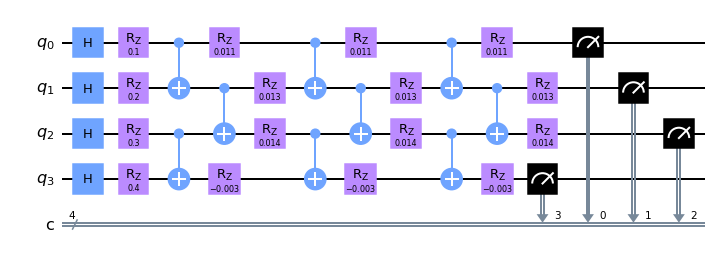

In [ ]:
###########################################
#  Custom Circuit - Qiskit (opcional)
#-------------------------------------------

#grafica el circuito con pennylane
#circuitoPersonalizado
print("circuitoPersonalizado:")

q1 = QuantumRegister(4, 'q')
c1 = ClassicalRegister(4, 'c')
circuito1 = QuantumCircuit(q1, c1)

#grafica con qiskit
def H(circuit, nqubits):
  for i in range(nqubits):
    circuit.h(i) #wires indica en que qubit se encuentra 0,1,2,3
def R(circuit, w, q):    
  for i, valor in enumerate(w): # el  valor de la rotacion (RX,RY,RZ) para la primera capa recibe las caracteristicas de entrada y para las capas subsecuentes recibe los pesos
    circuit.rz(valor, q[i])   
def CNOT(circuit, nqubits , q):
    # Bucle sobre indices pares: i=0,2,...N-2 
    # para 4 qbits: i=0,2
    for i in range(0, nqubits - 1, 2):
      circuit.cx( q[i], q[i+1] )
    # Bucle sobre indices impares:  i=1,3,...N-3           
    # para 4 qbits: i=1
    for i in range(1, nqubits - 1, 2):  
      circuit.cx( q[i], q[i+1] )

def medidas(circuit, nqubits, q, c):
  for i in range(nqubits):
    circuit.measure(q[i],c[i])

def CNOT_2(circuit, nqubits, q):
  for i in range(0, nqubits - 1,2):
    circuit.cx( q[i], q[i+1] )
    if (i <= nqubits-3):      
      circuit.cx( q[i+1], q[i+2] )
  if (nqubits>2):    
    circuit.cx( q[num_qubits-1], q[0] )

#circuitoPersonalizado (qiskit)
#---------------------------------

#capa H
H(circuito1, num_qubits)
# 1. capa de entrada  
R(circuito1, [0.1,0.2,0.3,0.4], q1)
# 2. capas de circuitos variacionales cuanticos  
for i in range(num_capas_q):
  CNOT(circuito1, num_qubits, q1)    
  #pesos
  R(circuito1, [0.011,0.013,0.014,-0.003], q1)  
# 3. capa de medidas
medidas(circuito1, num_qubits, q1, c1)

#grafica el circuito con quiskit
circuito1.draw('mpl')


In [ ]:
###########################################
# Basic Entangled layers - Qiskit (opcional)
#-------------------------------------------

#from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
#from numpy import pi

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.u3(1.8789056926642103, 0, -3.141592653589793, qreg_q[0])
circuit.u3(1.0672993497599401, 0, -3.141592653589793, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.u3(0.9097932246684819, 0, -3.141592653589793, qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(-0.00517308060079813, qreg_q[1])
circuit.u3(2.7233629981663565, 0, -3.141592653589793, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(-0.010997875593602657, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.022120095789432526, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(-0.0049829320050776005, qreg_q[1])
circuit.ry(0.0003761127882171422, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.01986064575612545, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(0.009680885821580887, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.006537382025271654, qreg_q[1])
circuit.ry(-0.02442200295627117, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(-0.011998500674962997, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.003337978385388851, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.0030636333394795656, qreg_q[1])
circuit.ry(0.011106514371931553, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(-0.005998092703521252, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(0.014049259945750237, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.016586050391197205, qreg_q[1])
circuit.ry(-0.031351666897535324, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.011636339128017426, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.010256115347146988, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(-0.004068305715918541, qreg_q[1])
circuit.ry(-0.012013716623187065, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.004836218431591988, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.009090042673051357, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(-0.0007264172891154885, qreg_q[1])
circuit.ry(0.0009281170787289739, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.03745159134268761, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.0006671973969787359, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.008990674279630184, qreg_q[1])
circuit.ry(0.014409597963094711, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.011229131370782852, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(-0.0015846880851313472, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.01213704701513052, qreg_q[1])
circuit.ry(0.008603476919233799, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.ry(0.012688403949141502, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.ry(0.01665543206036091, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(0.0032690975349396467, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])

circuitoPersonalizado Christian:


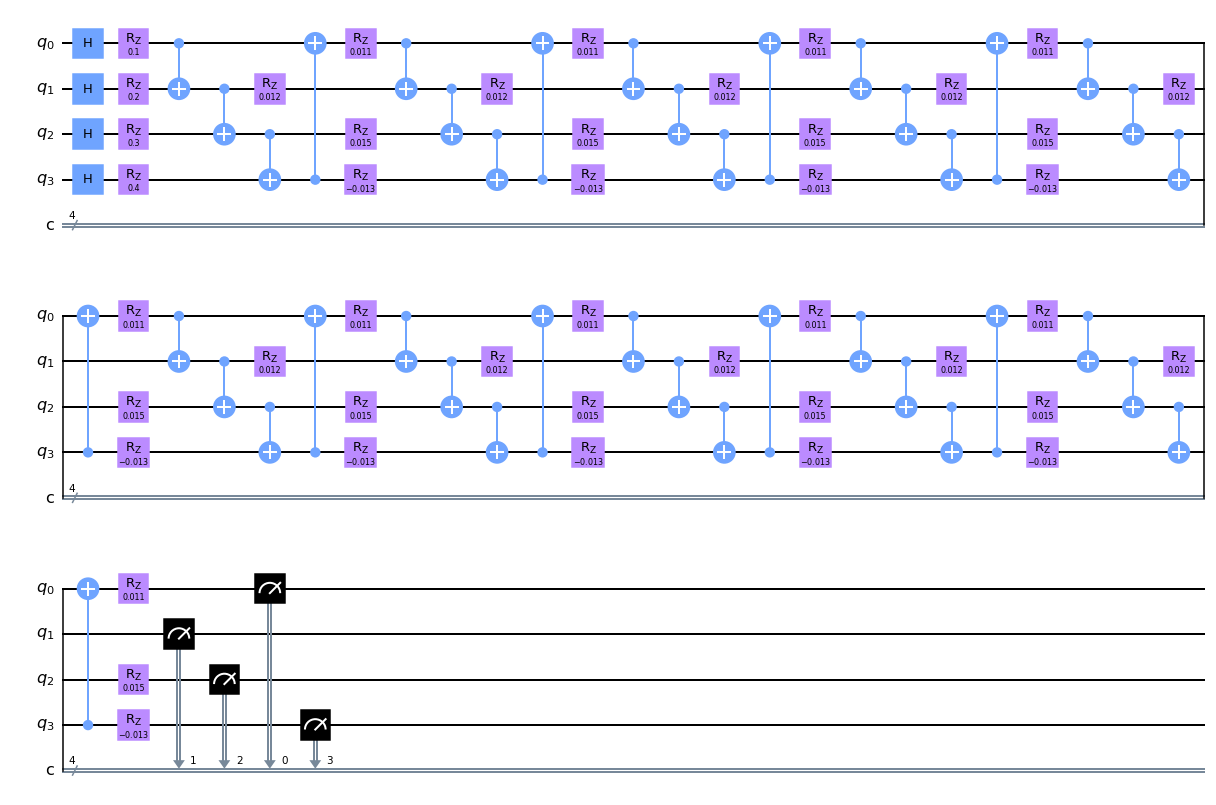

In [ ]:
#circuitoPersonalizado Christian (qiskit)
#----------------------------------------
print("circuitoPersonalizado Christian:")
q2 = QuantumRegister(4, 'q')
c2 = ClassicalRegister(4, 'c')

circuito2 = QuantumCircuit(q2, c2)
#capa H
H(circuito2, num_qubits)
# 1. capa de entrada  
R(circuito2, [0.1,0.2,0.3,0.4], q2)
# 2. capas de circuitos variacionales cuanticos  
for i in range(num_capas_q):
  CNOT_2(circuito2, num_qubits, q2)    
  #pesos
  R(circuito2, [0.011,0.012,0.015,-0.013], q2)  
# 3. capa de medidas
medidas(circuito2, num_qubits, q2, c2)

#grafica el circuito con quiskit
circuito2.draw('mpl')

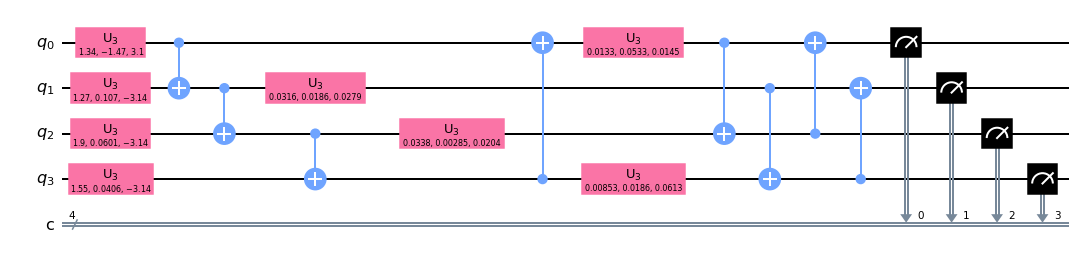

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.u3(1.343458226273267, -1.4704023870875078, 3.097435364472423, qreg_q[0])
circuit.u3(1.2682664804733925, 0.10726528772161092, -3.139959156441149, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.u3(1.9004118552684925, 0.06011281998060092, -3.1415263611743507, qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.u3(0.03156921890369263, 0.018565651452712384, 0.027939049925061354, qreg_q[1])
circuit.u3(1.5528304016909178, 0.04060175355254669, -3.1413453237774807, qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.u3(0.033791225108917015, 0.0028496989813890927, 0.02035401535131065, qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.u3(0.013303488950465462, 0.05331644558609616, 0.014549341531432614, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[0])
circuit.u3(0.008525197555142363, 0.01864025202150854, 0.061285970579096904, qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.cx(qreg_q[3], qreg_q[1])

circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])
circuit.draw('mpl')

In [ ]:
################################################################################################################
# Inicializacion y redimensionado de las redes pre-entrenadas con salidas clasicas y cuanticas [1]
# ----------------------------------------------------------------------------------------------------------
#

# Configurar parametros del Modelo. atributo requires_grad, hay que congelar todos los pesos porque no ellos no deberian ser entrenados
def poner_parametro_requires_grad(modelo, feature_extracting):
  if feature_extracting:
    for parametro in modelo.parameters():
      parametro.requires_grad = False

def inicializar_modelo(nombre_modelo, feature_extract, usa_preentrenado=True):
    # se configura el modelo pre-entrenado 
    modelo_ft = None
    tam_imagen = 0
    num_ftrs = 0

    if nombre_modelo == "resnet":
        # Resnet18        
        modelo_ft = models.resnet18(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.fc.in_features
        modelo_ft.fc = nn.Linear(num_ftrs, num_clases)
        #modelo_ft.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, num_clases))
        #modelo_ft.fc = nn.Sequential(nn.Linear(512, num_qubits), torch.nn.ReLU(), nn.Linear(num_qubits, num_clases)) 
        tam_imagen = 224

    elif nombre_modelo == "alexnet":
        # Alexnet        
        modelo_ft = models.alexnet(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.classifier[6].in_features
        modelo_ft.classifier[6] = nn.Linear(num_ftrs, num_clases)
        tam_imagen = 224

    elif nombre_modelo == "vgg":
        # VGG11_bn        
        modelo_ft = models.vgg11_bn(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.classifier[6].in_features
        modelo_ft.classifier[6] = nn.Linear(num_ftrs, num_clases)
        tam_imagen = 224

    elif nombre_modelo == "squeezenet":
        # Squeezenet        
        modelo_ft = models.squeezenet1_0(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        modelo_ft.classifier[1] = nn.Conv2d(512, num_clases, kernel_size=(1, 1), stride=(1, 1))
        modelo_ft.num_classes = num_clases
        tam_imagen = 224
    
    elif nombre_modelo == "densenet":
        # Densenet   
        # modelos que consisten en múltiples saltos paralelos     
        modelo_ft = models.densenet121(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.classifier.in_features
        modelo_ft.classifier = nn.Linear(num_ftrs, num_clases)
        tam_imagen = 224

    elif nombre_modelo == "inception":
        """ Inception v3 
        Ojo se espera un tamaño de las imagenes de  (299,299) y una salida auxiliar  """
        modelo_ft = models.inception_v3(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        # Se encarga de la red auxiliar
        num_ftrs = modelo_ft.AuxLogits.fc.in_features
        modelo_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_clases)
        # Se encarga de la red primaria
        num_ftrs = modelo_ft.fc.in_features
        modelo_ft.fc = nn.Linear(num_ftrs, num_clases)
        tam_imagen = 299

    elif nombre_modelo == "resnet_cuantico":
        # Resnet18 Cuantico        
        modelo_ft = models.resnet18(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.fc.in_features
        modelo_ft.fc = RedCuantica(num_ftrs)
        #modelo_ft.fc = RedCuantica()
        tam_imagen = 224   

    elif nombre_modelo == "densenet_cuantico":
        # Densenet Cuantico        
        modelo_ft = models.densenet121(pretrained=usa_preentrenado)
        poner_parametro_requires_grad(modelo_ft, feature_extract)
        num_ftrs = modelo_ft.classifier.in_features
        modelo_ft.classifier = RedCuantica(num_ftrs)
        tam_imagen = 224
    else:
        print("Nombre de modelo incorrecto, saliendo...")
        exit()

    return modelo_ft, tam_imagen, num_ftrs

###############################
# Escoger modelo Pre-entrenado
# -----------------------------
#
num_caract = 0
nombre_modelo = "resnet_cuantico"
modelo_ft,  tam_imagen, num_caract = inicializar_modelo(nombre_modelo, feature_extract, usa_preentrenado=True)

# Muestra la estructura del modelo prenetrenado escogido, lo mas importante es ver la capa final 
print(f"Modelo: {modelo_ft}\n")

print(f"Nombre modelo: {nombre_modelo}\nTamaño de la imagen: {tam_imagen}\nNumero de Caracteristicas: {num_caract} ")

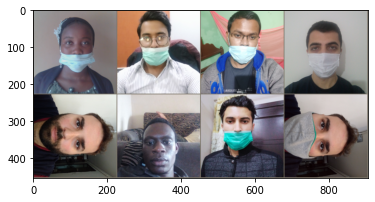

In [ ]:
########################################################
# Carga de los datos de entrada
# -------------------------------------
#
# Cada clase tiene 150 imagenes para entrenamiento 450 en total y 70 imaganes por cada clase para las pruebas 210 en total
# los valores de reescalado, rotacion, desviacion estandar y valor medio (normalizacion) dependen de que modelo  preentrenado estemos usando 

# ruta en mi google drive donde estan las imagenes
data_dir = '/content/drive/MyDrive/data/rostros'

# Transformaciones y normalizacion para el entrenamiento y validadción
data_transforms = {
    'entrenamiento': transforms.Compose([
        #transforms.RandomResizedCrop(tam_imagen),    # Hacer redimensionado aleatorio y recorte da malos resultados 
        transforms.RandomHorizontalFlip(),            # la rotacion permite tener mas situaciones de prueba
        transforms.Resize(tam_imagen),                # tamaño de la imagen de 224x224
        transforms.CenterCrop(tam_imagen),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #valor medio y desviacion estandar exigidos por los modelos preentrenados
    ]),
    'pruebas': transforms.Compose([
        transforms.Resize(tam_imagen),
        transforms.CenterCrop(tam_imagen),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}    
  
# Crea el dataset de entrenamiento y pruebas
dataset_imagenes = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['entrenamiento', 'pruebas']}

#texto de las clases de las imagenes
nombres_clases = dataset_imagenes['entrenamiento'].classes

# Obtener los indices de las muestras aociadas con las clases filtradas 
etiquetas_filtradas = [nombres_clases.index(cl) for cl in nombres_clases]

#numero de muestras
dataset_sizes = {x: len(dataset_imagenes[x]) for x in ['entrenamiento', 'pruebas']} 

# Mapear etiquetas (0,1,2,3,4,5,6,7,8,9) para los indices de  etiquetas_a_filtrar
def etiquetas_a_filtrar(etiquetas):    
  return [etiquetas_filtradas.index(etiqueta) for etiqueta in etiquetas]

# Diccionario que contiene los datos cargados tanto de entrenamiento como para las pruebas
datos_cargados_dict = {  x: torch.utils.data.DataLoader(dataset_imagenes[x], batch_size=tam_lote, shuffle=True, num_workers=2) for x in ['entrenamiento', 'pruebas']}


########################################################
# Visualizacion por bloques de los datos de entrada
# ------------------------------------------------------
# Vemos como quedan las imagenes despues de las transformaciones escogidas: reescalado, rotacion, normalizacion, etc.

# Funcion para plotear imagenes de tensores
def muestra_imagen(inp, titulo=None):
  # Muestra imagen del Tensor
  inp = inp.numpy().transpose((1, 2, 0))
  
  # Aplicamos la inversa de la operacion de normalizacion inicial
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if titulo is not None:
    plt.title(titulo)    
  #plt.pause(0.001) #pausa no funciona bien

# Obtenemos un lote de los datos de entrenamiento
entradas, clases = next(iter(datos_cargados_dict['entrenamiento']))

# Hacemos un grid del lote 
salida = torchvision.utils.make_grid(entradas, nrow=4)


muestra_imagen(salida)

##############################
# Creacion del optimizador
# ----------------------

# Ejecutar el modelo en el GPU
modelo_ft = modelo_ft.to(procesador)
parametros_a_actualizar = modelo_ft.parameters()

#print("Parametros para aprendizaje: ")
if feature_extract:
  parametros_a_actualizar = []
  for name, param in modelo_ft.named_parameters():
    if param.requires_grad == True:
      parametros_a_actualizar.append(param)
      #print("\t", name) #descomentar cuanto se quiera ver los parametros
      a=name
else:
  for name, param in modelo_ft.named_parameters():
    if param.requires_grad == True:
      #print("\t", name) #descomentar cuanto se quiera ver los parametros
      a=name

optminizador_nombre = "Adam"
# Observe que todos los parametros estan siendo optimizados [4]
#optimizador_ft = optim.SGD(parametros_a_actualizar, lr=0.001, momentum=0.9, nesterov=True) #Stochastic gradient descent 

optimizador_ft = optim.Adam(parametros_a_actualizar, lr=0.0004)


In [ ]:
#########################################
# Entrenamiento
# -----------------------------------
#
# Los parametros de entrada son: un modelo pytorch, un diccionario de datos cargados ,una funcion de perdida, un optimizador, un numero especifico de epocas para entrenar 
# y validar, y un flag  *es_inception* el cual es usado para modificar el modelo para su uso con Inception v3, este trabaja con una salida auxiliar y una perdida general 
# del modelo  respecto a la salida auxiliar y la salida final, como se describe en [5].

def entrenar_modelo(modelo, datos_cargados, funcion_perdida, optimizador, num_epocas=25, es_inception=False):
    # hora de inicio
    inicio = time.time()
    exactitud_historico = []
    mejor_exac = 0.0
    mejor_error = 10000.0   # numero arbitrariamente largo
    mejor_exac_entrena = 0.0
    mejor_error_entrena = 10000.0  # numero arbitrariamente largo

    #recuperar donde nos quedamos entrenando
    #mejor_modelo_wts = copy.deepcopy(modelo.state_dict())    
    
    print(f"\nEntrenamiento {nombre_modelo} - {circuito_op} - {optminizador_nombre} iniciado:\n")     
    for epoca in range(1, num_epocas + 1):
        print('Epoca {}/{}'.format(epoca, num_epocas))
        print('-' * 10)

        # Cada epoca tiene una fase de entrenamiento y pruebas 
        for fase in ['entrenamiento', 'pruebas']:
            if fase == 'entrenamiento':
                modelo.train()  # Poner modelo a modo entrenamiento 
            else:
                modelo.eval()  # Poner modelo a modo evaluacion

            ejecucion_error = 0.0
            ejecucion_correctos = 0

            # Itera sobre los datos.
            for entradas, etiquetas in datos_cargados[fase]:
                entradas = entradas.to(procesador)
                etiquetas = etiquetas.to(procesador)

                # limpia viejos gradientes 
                optimizador.zero_grad()

                # forward                
                with torch.set_grad_enabled(fase == 'entrenamiento'):
                    # Obtener las salidas del modelo y calcular el error. El caso especial es inception porque en su entrenamiento este tiene una salida auxiliar.
                    # En el modo entrenaiento calculamos el error sumando la salida final y la salida auxiliar pero para las pruebas solo consideramos la salida final.
                    if es_inception and fase == 'entrenamiento':
                        # ojo no te olvides de profundizar en  [5]
                        salidas, salidas_aux = modelo(entradas)
                        error1 = funcion_perdida(salidas, etiquetas)
                        error2 = funcion_perdida(salidas_aux, etiquetas)
                        error = error1 + 0.4 * error2
                    else:
                        salidas = modelo(entradas) #resultado de probar el modelo
                        error = funcion_perdida(salidas, etiquetas) # calcula el error de la prueba

                    _, preds = torch.max(salidas, 1) # hallamos la exactitud, devuelve el mejor valor de la prediccion (el mas grande)

                    # backward + optimize solo se ejecuta en entrenamiento
                    if fase == 'entrenamiento':
                        error.backward() 
                        optimizador.step() 

                # estadisticas
                ejecucion_error += error.item() * entradas.size(0)
                ejecucion_correctos += torch.sum(preds == etiquetas.data)

                #guardado del entrenamiento para retomar, solo para modelos extensos con vgg o alexnet despues no amerita si uso cuda                                                                
                #torch.save(optimizador.state_dict(), path_modelos + nombre_modelo + "_opt.pth")
                #torch.save(modelo.state_dict(), path_modelos + nombre_modelo + "_mod.pth")                


            epoca_error = ejecucion_error / len(datos_cargados[fase].dataset)
            epoca_exac = ejecucion_correctos.double() / len(datos_cargados[fase].dataset)

            print('{}, Error: {:.4f} Exactitud: {:.4f}'.format(fase, epoca_error, epoca_exac))


            # Check if this is the best model wrt previous epochs
            if fase == 'pruebas' and epoca_exac > mejor_exac:
              mejor_exac = epoca_exac
              #mejor_modelo_wts = copy.deepcopy(modelo.state_dict())
            if fase == 'pruebas' and epoca_error < mejor_error:
              mejor_error = epoca_error
            if fase == 'entrenamiento' and epoca_exac > mejor_exac_entrena:
              mejor_exac_entrena = epoca_exac
            if fase == 'entrenamiento' and epoca_error < mejor_error_entrena:
              mejor_error_entrena = epoca_error
            if fase == 'pruebas':
              exactitud_historico.append(epoca_exac)

        print()        

    # cargar los mejores pesos del modelo
    #modelo.load_state_dict(mejor_modelo_wts)

    # Muestra los resultados finales    
    tiempo_transcurrido = time.time() - inicio
    print('Entrenamiento completado en {:.0f}m {:.0f}s'.format(tiempo_transcurrido // 60, tiempo_transcurrido % 60))
    print('pruebas, Minimo Error: {:.4f} | Mejor exactitud: {:.4f}'.format(mejor_error, mejor_exac))    
    
    #guardamos los valores finales 
    torch.save({'nombre': nombre_modelo,
                'epocas': epoca, 
                'error': mejor_error,
                'exactitud':float(mejor_exac),
                'tiempo': float(tiempo_transcurrido // 60),
                'tam_lote' : tam_lote,
                'modelo': modelo.state_dict(),
                'optimizador': optimizador.state_dict(),
                'num_qubits':num_qubits,
                'num_capas_q':num_capas_q,
                'metodo_dif': metodo_dif,
                'rotacion' : rotacion,
                'shots': shots,
                'circuito': circuito_op},
                 path_modelos + nombre_modelo + "_modelo.pth")
 
    return modelo, exactitud_historico

###########################################################
# Ejecutar entrenamiento y proceso de validacion (pruebas)
# -------------------------------------------------------

# Configurar la funcion de perdida
funcion_perdida = nn.CrossEntropyLoss().to(procesador)

# entrenar y evaluar
modelo_ft, hist = entrenar_modelo(modelo_ft, datos_cargados_dict, funcion_perdida, optimizador_ft, num_epocas, es_inception=(nombre_modelo == "inception"))

In [ ]:
##################################
# Carga modelo guardado
#------------------------------

#cargamos los datos guardados 
path = path_modelos + nombre_modelo + "_cc_30_ADAM.pth"
modelo_guardado = torch.load(path)

# recupera los resultados clasicos
modelo_ft.load_state_dict(modelo_guardado['modelo'])
optimizador_ft.load_state_dict(modelo_guardado['optimizador'])
nombre = modelo_guardado['nombre']
epocas = modelo_guardado['epocas']
error = modelo_guardado['error']
exactitud = modelo_guardado['exactitud']
tiempo = modelo_guardado['tiempo']
lote = modelo_guardado['tam_lote']

print("Modelo cargado")
print('-' * 15)

print('Nombre: ', nombre)
#print("modelo: ",modelo_ft,"\n")
print("Epocas: ", epocas)
print("Tam lote: ", lote)
print("Minimo error: ", error )
print("Mejor exactitud: ", exactitud)
print("Tiempo transcurrido: ", tiempo, "min")

# recupera los resultados cuanticos para el caso hibrido
if nombre_modelo in ["resnet_cuantico", "densenet_cuantico"] :
  qubits = modelo_guardado['num_qubits']
  shots = modelo_guardado['shots']
  capas_q = modelo_guardado['num_capas_q']
  rotacion_eje = modelo_guardado['rotacion']
  met_diff = modelo_guardado['metodo_dif']
  circuito = modelo_guardado['circuito']
  
  print("Numero de qubits: ", num_qubits)
  print("Numero de shots: ", shots)
  print("Numero de capas cuanticas: ", capas_q)
  print("Metodo de diferenciacion: ", met_diff)
  print("Rotacion eje: ", rotacion_eje)
  print("Circuito: ", circuito)


print("Optimizador: ", optimizador_ft,"\n")



Modelo cargado
---------------
Nombre:  resnet_cuantico
Epocas:  30
Tam lote:  8
Minimo error:  0.17945557435353596
Mejor exactitud:  0.9857142857142858
Tiempo transcurrido:  127.0 min
Numero de qubits:  4
Numero de shots:  385
Numero de capas cuanticas:  10
Metodo de diferenciacion:  reversible
Rotacion eje:  Y
Circuito:  circuitoPersonalizado
Optimizador:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0004
    weight_decay: 0
) 



Predicciones: 


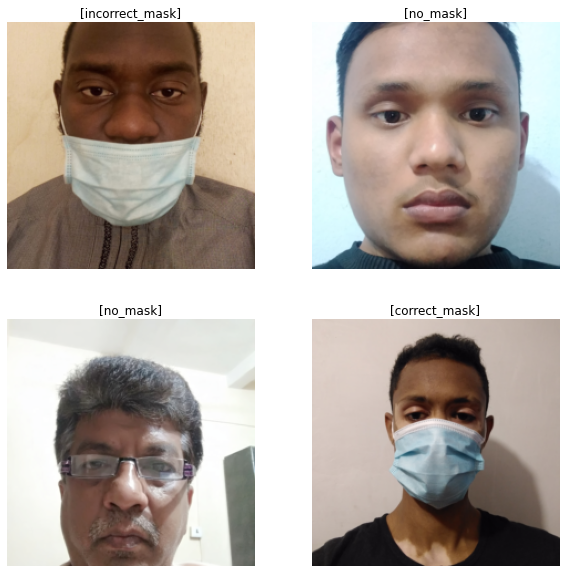

In [ ]:
######################################################################
# Visualizacion de la prediccion [3]
#------------------------------------------
# num_imagenes es el total de imagenes a mostrar en la prediccion, no tiene nada que ver con el lote (batch_size)

def visualiza_modelo(modelo, num_imagenes=6, nombre_figura='Predicciones'):
    cont_imagenes = 0   # contador de imagenes procesadas correctamente hasta ahora
    fig = plt.figure(nombre_figura, figsize=(10,10)) #redimensionamos el tamaño de la imagen
    
    modelo.eval()
    with torch.no_grad():
        for i, (entradas, _etiquetas) in enumerate(datos_cargados_dict['pruebas']):            
            entradas = entradas.to(procesador)
            etiquetas = torch.tensor(etiquetas_a_filtrar(_etiquetas))
            etiquetas = etiquetas.to(procesador)
            salidas = modelo(entradas)
            _, preds = torch.max(salidas, 1)
            for j in range(entradas.size()[0]):
                cont_imagenes += 1
                ax = plt.subplot(num_imagenes // 2, 2, cont_imagenes )
                ax.axis('off')
                ax.set_title('[{}]'.format(nombres_clases[preds[j]]))
                muestra_imagen(entradas.cpu().data[j])
                if cont_imagenes == num_imagenes:
                    return


#visualizamos el modelo 
print("Predicciones: ")
visualiza_modelo(modelo_ft, num_imagenes=4)

In [ ]:
#############################################
# Calculo Matriz de confusion 
#-----------------------------------------
# Son 210 imagenes de prueba 70 por cada clase

from sklearn.metrics import confusion_matrix, classification_report

# Inicializamos las listas resultado
predlist = torch.zeros(0,dtype=torch.long, device=procesador)
lbllist = torch.zeros(0,dtype=torch.long, device=procesador)

# Iteramos para obtener las predicciones con las imagenes de prueba
with torch.no_grad():
    for i, (entradas, clases) in enumerate(datos_cargados_dict['pruebas']):
        entradas = entradas.to(procesador)
        clases = clases.to(procesador)
        salidas = modelo_ft(entradas)
        _, preds = torch.max(salidas, 1)

        # Añade a listas valores correctos y predecidos
        lbllist = torch.cat([lbllist, clases.view(-1).to(procesador)]) # valores de entrada correctos "y_true"
        predlist = torch.cat([predlist, preds.view(-1).to(procesador)]) # predicciones del clasificador "y_pred"
        
#print(f"valores de verdad: {lbllist}")
#print(f"valores predecidos: {predlist}")

# Matriz de confusion (y_true, y_pred)
matriz_confusion = confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
print(f" Matriz de confusion:\n {matriz_confusion}")

# Exactitud por clase
exactitud_por_clase = 100 * matriz_confusion.diagonal() / matriz_confusion.sum(1)
print(exactitud_por_clase)

Matriz de confusion: 



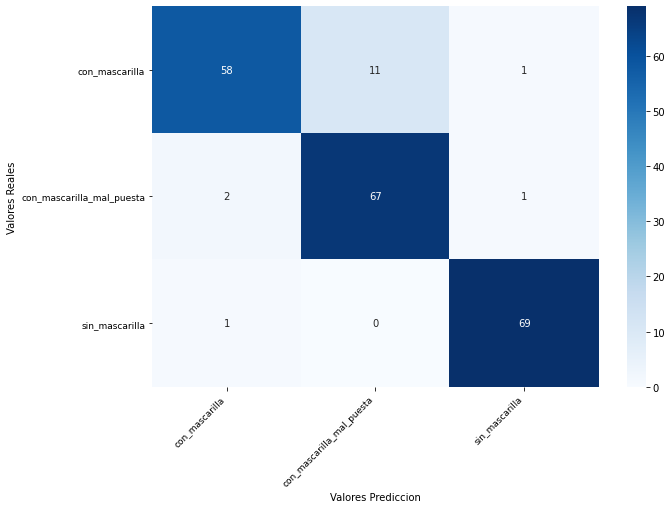

In [ ]:
#################################################
# Visualización Matriz de confusion 
#
import pandas as pd
import seaborn as sns

print("Matriz de confusion: ")
plt.figure(figsize=(10,7))

# Data frame cuadrado cuyos datos son los de la matriz de confusion
datos = pd.DataFrame(matriz_confusion, index=nombres_clases, columns=nombres_clases).astype(int)
# creamos un mapa de calor de color azul
mapa_calor = sns.heatmap(datos, annot=True, cmap='Blues', fmt="d")

#configura las etiquetas de los ejes x e y del mapa de calor
mapa_calor.yaxis.set_ticklabels(mapa_calor.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=9)
mapa_calor.xaxis.set_ticklabels(mapa_calor.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=9)
plt.ylabel("Valores Reales")
plt.xlabel("Valores Prediccion")
print()

In [ ]:
#################################################
# Reporte de Clasificación
#-------------------------------------

print(f"Reporte de Clasificacion para {nombre_modelo}:\n" f"{classification_report  (lbllist.cpu().numpy(), predlist.cpu().numpy(), target_names=nombres_clases)}\n")

Reporte de Clasificacion para resnet_cuantico:
                precision    recall  f1-score   support

  correct_mask       1.00      0.97      0.99        70
incorrect_mask       0.97      0.96      0.96        70
       no_mask       0.96      1.00      0.98        70

      accuracy                           0.98       210
     macro avg       0.98      0.98      0.98       210
  weighted avg       0.98      0.98      0.98       210




In [ ]:
"""
#############################################
# Calculo Matriz de confusion (version 2)
#
# Son 210 imagenes de prueba 70 por cada clase
matriz_confusion = torch.zeros(num_clases, num_clases)  #iniciamos con una matriz cuadrada
with torch.no_grad():
    for i, (entradas, clases) in enumerate(datos_cargados_dict["pruebas"]):
        entradas = entradas.to(procesador) # entradas al gpu
        clases = clases.to(procesador)    # clases al gpu
        salidas = modelo_ft(entradas)
        _, preds = torch.max(salidas, 1)
        for t, p in zip(clases.view(-1), preds.view(-1)):
                matriz_confusion[t.long(), p.long()] += 1
print(matriz_confusion)
print("matriz de confusion calculada satisfactoriamente")


#imprime exactitud por cada clase clase 
print("Precicion por cada clase: ")
print(nombres_clases)
print(matriz_confusion.diag()/matriz_confusion.sum(1))
"""

### Referencias
[1] https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 

[2] https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html

[3] https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

[4] https://github.com/XanaduAI/quantum-transfer-learning/blob/master/c2q_transfer_learning_cifar.ipynb

[5] https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

[6] https://arxiv.org/abs/1512.03385